
🧹 ADIM 1: Veri Yükleniyor ve Temizleniyor...
✅ Veri Hazır! Boyut: (638454, 10)

🔍 ADIM 2: İstatistiksel Özellik Seçimi (Chi-Square)
✅ Seçilen Kategorik Özellikler (6 adet):
   Agency_Type, Month, Crime_Type, Victim_Sex, Victim_Race, Weapon

🤖 ADIM 3: Model Hazırlığı ve Eğitim
✅ Model başarıyla eğitildi.

📊 ADIM 4: Performans Raporu
Doğruluk (Accuracy): 0.6121

--- Sınıflandırma Detayı ---

              precision    recall  f1-score   support

           0       0.41      0.65      0.50     57125
           1       0.80      0.60      0.68    134412

    accuracy                           0.61    191537
   macro avg       0.60      0.62      0.59    191537
weighted avg       0.68      0.61      0.63    191537


--- Güvenilirlik Analizi (10-Fold CV - Class 0 Recall) ---
Ortalama: 0.5277  |  Standart Sapma: ±0.2023


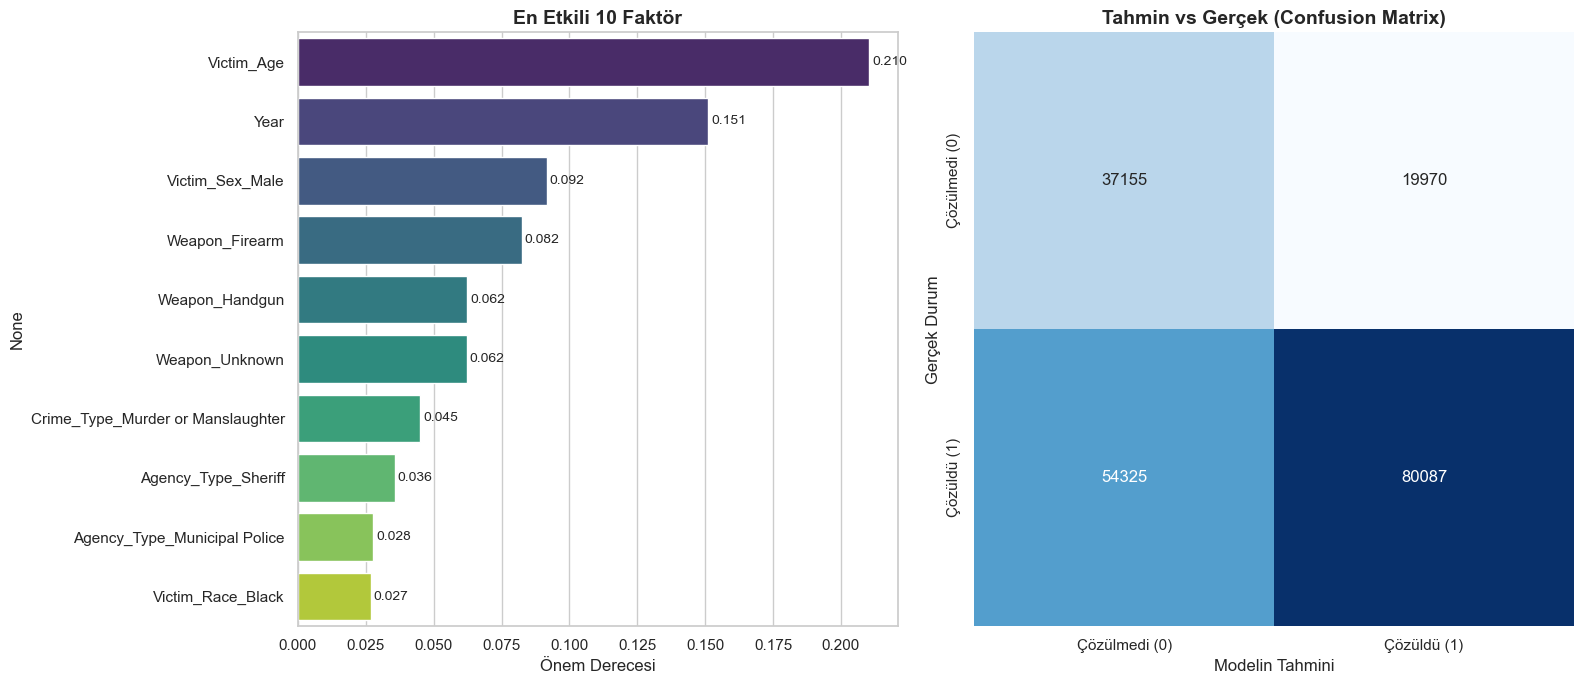

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings

# Sklearn Kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve, 
                             average_precision_score, log_loss, cohen_kappa_score, make_scorer, recall_score)

# --- AYARLAR ---
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (20, 6) # Grafikler geniş olsun

# --- 1. FONKSİYON: VERİ YÜKLEME VE ÖN İŞLEME ---
def veri_yukle_ve_temizle(dosya_yolu):
    print("\n" + "="*50)
    print("🧹 ADIM 1: Veri Yükleniyor ve Temizleniyor...")
    print("="*50)
    
    df = pd.read_csv(dosya_yolu, low_memory=False)

    # Sütun isimlerini standartlaştır
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

    # Gereksiz veya Sızıntı Yaratacak Sütunlar (Leakage Prevention)
    silinecek_sutunlar = [
        'Record_ID', 'Incident', 'Agency_Code', 'City', 'Agency_Name', 
        'Victim_Count', 'Perpetrator_Count', 'Record_Source', 
        'Victim_Ethnicity', 'Perpetrator_Ethnicity',
        'Perpetrator_Sex', 'Perpetrator_Age', 'Perpetrator_Race', 'Relationship'
    ]
    df.drop(columns=silinecek_sutunlar, errors='ignore', inplace=True)

    # Eksik Veri Doldurma
    df['Victim_Age'] = pd.to_numeric(df['Victim_Age'], errors='coerce')
    df['Victim_Age'] = df['Victim_Age'].fillna(df['Victim_Age'].median()) # Median daha sağlamdır
    
    print(f"✅ Veri Hazır! Boyut: {df.shape}")
    return df

# --- 2. FONKSİYON: ÖZELLİK SEÇİMİ (Ki-Kare / Chi-Square) ---
def ozellik_secimi(df, target_col, alpha=0.05, max_unique=50):
    print("\n" + "="*50)
    print("🔍 ADIM 2: İstatistiksel Özellik Seçimi (Chi-Square)")
    print("="*50)
    
    kategorik_sutunlar = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in kategorik_sutunlar: kategorik_sutunlar.remove(target_col)

    secilenler = []
    
    for col in kategorik_sutunlar:
        # Çok fazla benzersiz değeri olanları (örn: Tarih, İsim) atla, Chi-Square'i bozar
        if df[col].nunique() > max_unique: continue
        
        crosstab = pd.crosstab(df[col].dropna(), df[target_col].dropna())
        if crosstab.shape[0] > 1 and crosstab.shape[1] > 1:
            try:
                _, p, _, _ = chi2_contingency(crosstab)
                if p < alpha: secilenler.append(col)
            except ValueError: continue

    print(f"✅ Seçilen Kategorik Özellikler ({len(secilenler)} adet):")
    print(f"   {', '.join(secilenler)}")
    return secilenler

# --- 3. FONKSİYON: MODEL EĞİTİMİ (DECISION TREE) ---
def model_egitimi(df, secilen_ozellikler, target_col):
    print("\n" + "="*50)
    print("🤖 ADIM 3: Model Hazırlığı ve Eğitim (Decision Tree)")
    print("="*50)
    
    # Sayısal sütunları al
    sayisal_sutunlar = df.select_dtypes(include=['number']).columns.tolist()
    if target_col in sayisal_sutunlar: sayisal_sutunlar.remove(target_col)

    # Encoding
    kullanilacak_sutunlar = secilen_ozellikler + sayisal_sutunlar + [target_col]
    df_model = df[kullanilacak_sutunlar].copy()
    
    # One-Hot Encoding
    df_encoded = pd.get_dummies(df_model, columns=secilen_ozellikler, drop_first=True)
    
    # Target Encoding
    # Yes/No -> 1/0 dönüşümü (Otomatik algılar)
    if df_encoded[target_col].dtype == 'object':
         df_encoded[target_col] = df_encoded[target_col].astype('category').cat.codes

    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Model Tanımlama
    clf = DecisionTreeClassifier(
        max_depth=15,               
        class_weight='balanced',    
        criterion='entropy',        
        random_state=42
    )
    
    clf.fit(X_train, y_train)
    print("✅ Model başarıyla eğitildi.")
    
    return clf, X, y, X_test, y_test

# --- 4. FONKSİYON: KAPSAMLI RAPORLAMA VE GÖRSELLEŞTİRME ---
def raporla_ve_gorsellestir(model, X, y, X_test, y_test):
    # Tahminler
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Olasılıklar (ROC ve LogLoss için)
    
    # Metrik Hesaplamaları
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    logloss = log_loss(y_test, y_pred_proba)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    print("\n" + "="*50)
    print("       DETAYLI MODEL PERFORMANS RAPORU       ")
    print("="*50)
    print(f"Model: Decision Tree Classifier")
    print(f"Feature Selection: Chi-Square")
    print("-" * 50)
    print(f"1. Accuracy (Doğruluk):      {accuracy:.4f}")
    print(f"2. ROC AUC Score:            {roc_auc:.4f} (Ayırt Edicilik)")
    print(f"3. Cohen's Kappa:            {kappa:.4f} (Şans faktöründen arındırılmış)")
    print(f"4. Log Loss:                 {logloss:.4f} (Hata Payı)")
    print("-" * 50)
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # --- Feature Importance Yazdırma (Metin Olarak) ---
    print("-" * 50)
    print("ÖZELLİK ÖNEM DERECELERİ (Top 10):")
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    print(feature_importances.nlargest(10))
    print("="*50)

    # --- GRAFİKLER (3'lü Dashboard) ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Tahmin Edilen')
    axes[0].set_ylabel('Gerçek Değer')
    axes[0].set_xticklabels(['Çözülemedi', 'Çözüldü'])
    axes[0].set_yticklabels(['Çözülemedi', 'Çözüldü'])

    # 2. ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Eğrisi')
    axes[1].legend(loc="lower right")

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    axes[2].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.2f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Eğrisi')
    axes[2].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# --- ANA AKIŞ ---
if __name__ == "__main__":
    DOSYA_ADI = "US_Crime_DataSet.csv"
    TARGET = 'Crime_Solved' # CSV'deki adıyla aynı olmalı (Boşlukları _ yapıyor fonksiyon)

    # Akışı çalıştır
    df = veri_yukle_ve_temizle(DOSYA_ADI)
    # Temizledikten sonra sütun isimleri değiştiği için target adını güncelle (Boşluk yerine _)
    TARGET = 'Crime_Solved' 
    
    secilenler = ozellik_secimi(df, TARGET)
    model, X, y, X_test, y_test = model_egitimi(df, secilenler, TARGET)
    raporla_ve_gorsellestir(model, X, y, X_test, y_test)